**Predicting Newsletter Subscription Among Minecraft Server Players Using Gameplay Activity**

**Background:**
Minecraft is a popular sandbox video game that allows players to explore, build, and interact within a block-based virtual world. Due to its capability to attract a wide range of players, researchers are using it as a platform for studying behavior.

In this project, a research team at UBC has deployed a custom Minecraft server to collect detailed data on player activity.The server logs their sessions. This behavioral dataset uses variables such as player age and playtime to specifically explore whether players choose to subscribe to a newsletter related to the game based on these conditions. By analyzing these patterns, we aim to build a predictive model that can help identify the most engaged users based on their in-game behavior. 

**Question:Is a player’s age or played hours more predictive of whether their subscription to the game-related newsletter?**

**Data Description:**

In [1]:
library(tidyverse)
library(tidymodels)
library(tidyclust)
library(forcats)
library(repr)
library(themis)
options(repr.matrix.max.rows = 6)
source("cleanup.R")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


In [2]:
players = read_csv("players.csv")

players

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


The players dataset used for this analysis consists of 197 observations and 7 variables. It contains information on players of a Minecraft research server, including demographic details, gameplay statistics, and subscription status.

The key variables are summarized below:

Variable 1 (experience): character — player experience level in minecraft Variable 2 (subscribe): logic — whether or not the player is subscribed to the newsletter (TRUE is subscribed, FALSE is not subscribed) Variable 3 (hashedEmail): character — hashed email of the player to protect privacy Variable 4 (played_hours): numeric (decimal number) — number of hour the player has played Variable 5 (name): character — the name of the player Variable 6 (gender): character — gender of the player Variable 7 (Age): numeric (decimal number) — age of the player in years

The data includes both numeric and categorical variables. The response variable for this analysis is subscribe, which indicates whether a player subscribed to the game-related newsletter.

The data includes both numeric and categorical variables. The response variable for this analysis is subscribe, which indicates whether a player subscribed to the game-related newsletter.

Some considerations about the data:

The dataset may contain missing or inconsistent values, which will be addressed during data cleaning. Certain variables, such as hashedEmail and name, serve as unique identifiers and will not be used as predictors. The data were collected through player activity logs and subscription records from the Minecraft research server. Potential limitations include sample size constraints and possible self-reporting bias in demographic variables like gender and age. 

**Methods Description**

In [3]:
players = players|>
as_tibble() |>
select(Age, played_hours, subscribe) |>
filter(played_hours != 0.0) |>
filter(Age != "NA") |>
 mutate(subscribe = as.factor(subscribe)) |>
 mutate(subscribe = fct_recode(subscribe, "subscribed" = "TRUE", "unsubscribed" = "FALSE"))
players


Age,played_hours,subscribe
<dbl>,<dbl>,<fct>
9,30.3,subscribed
17,3.8,subscribed
21,0.7,subscribed
⋮,⋮,⋮
44,0.1,subscribed
22,0.3,unsubscribed
17,2.3,unsubscribed


Here, I take only the three variables that i need for answering my questions. thebn, i filter out any rows with the value such as "NA" or "0.0" that are useless values for the data analysis. Lastly, i make sure subsribe is a factor that can later be predicted properly. 

In [5]:
subscribe_true = players |>
filter(subscribe == "subscribed") |>
count(subscribe)
subscribe_true
subscribe_false = players |>
filter(subscribe == "unsubscribed") |>
count(subscribe)
subscribe_false

subscribe,n
<fct>,<int>
subscribed,84


subscribe,n
<fct>,<int>
unsubscribed,25


I first count the number of the two binary types to check if there is a factor imblanace. due to this imbalance, i will oversample subscribe=false in my recipe to balance the two. 

In [6]:
players_recipe <- recipe(subscribe ~ ., data = players) |>
  step_upsample(subscribe, over_ratio = 1, skip = FALSE) |>
prep()
players_clean = bake(players_recipe, players)
players_clean |>
  group_by(subscribe) |>
  summarize(n = n())

subscribe,n
<fct>,<int>
unsubscribed,84
subscribed,84


here, i rebalanced this factor variable to make sure the imbalance from the data set will not affect my analysis later on. 

Below, i will visualize the data differently to better understand the relationship between my variables, which will aid mt analysis later on.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


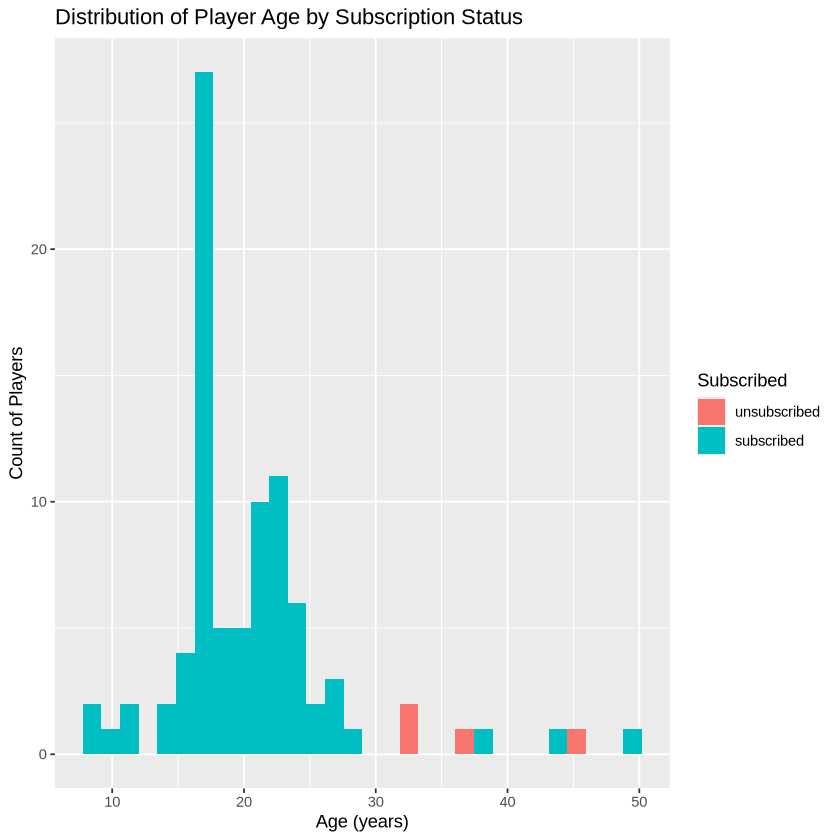

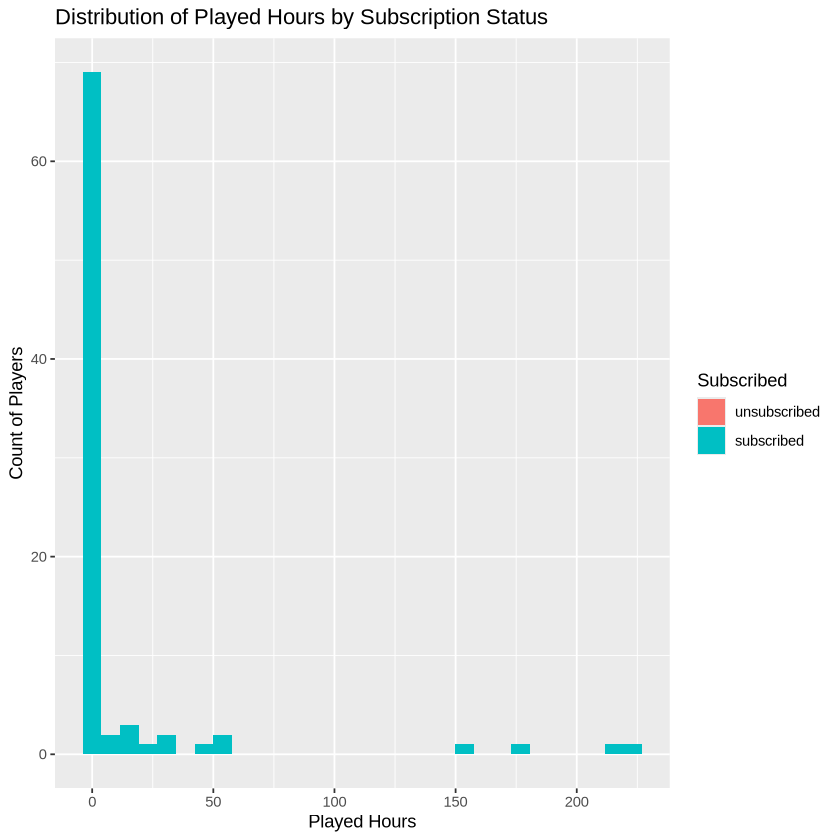

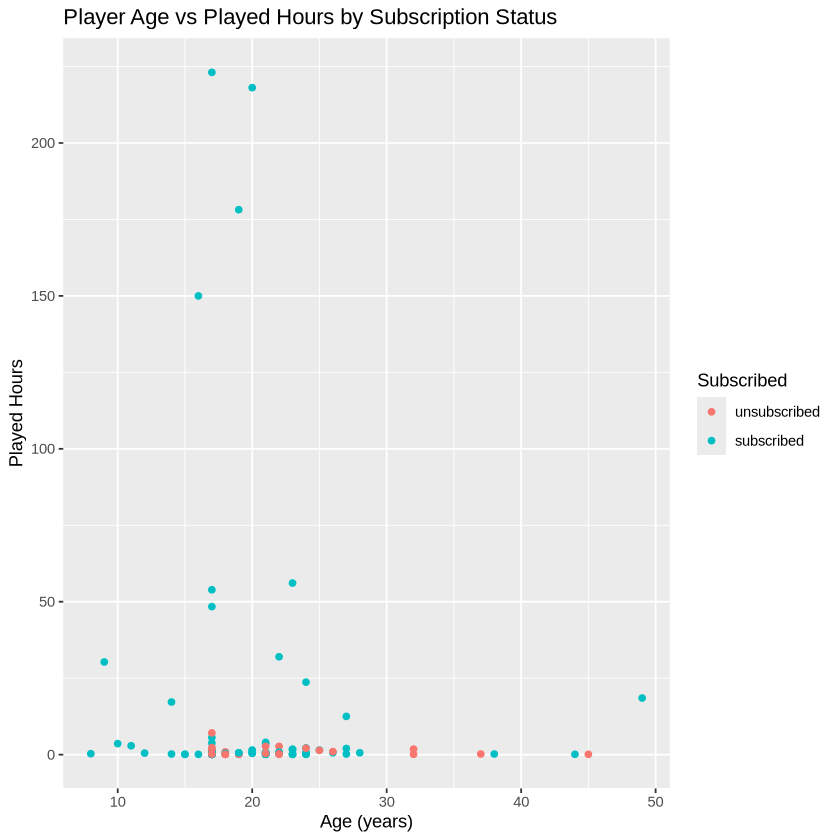

In [7]:
library(ggplot2)

# Histogram of Age by subscription 
ggplot(players, aes(x = Age, fill = subscribe)) +
  geom_histogram(position = "identity") +
  labs(title = "Distribution of Player Age by Subscription Status",
    x = "Age (years)",
    y = "Count of Players",
    fill = "Subscription")
  

# Histogram of Played Hours by subscription 
ggplot(players, aes(x = played_hours, fill = subscribe)) +
  geom_histogram(position = "identity") +
  labs(title = "Distribution of Played Hours by Subscription Status",
    x = "Played Hours",
    y = "Count of Players",
    fill = "Subscription")
 

# Scatterplot of Age vs Played Hours
ggplot(players, aes(x = Age, y = played_hours, color = subscribe)) +
  geom_point() +
  labs(title = "Player Age vs Played Hours by Subscription Status",
    x = "Age (years)",
    y = "Played Hours",
    color = "Subscription")



here, i used the "players" data frame because i dont want to rebalance for the exploratory data frame to visualize the data as they already are. 

in the histogram for the Distribution of Player Age by Subscription Status, the data is centered around age of 30, but the most visible cluster apear from age 10 to 20. This cluster consists of purely subscribed players with no apparent unsubscribed players. Unsubscribed players appear from age 30 to 50 onwards, and are much less in number in comparison to players from younger age groups. 

in the histogram for Distribution of Played Hours by Subscription Status, most players cluster around the range near very little playtime, but they were all subscribed to the newsletter. No unsubscribed player were shown on the histogram, and they possibily had too little playtime to occur on the plot. 

in the scatterplot for Player Age vs Played Hours by Subscription Status, there is no strong relationship between the two variables since no pattern is observed in the plot and there is too much noise as the points scatter everywhere. 

Insights from the analysis relative to my predictive questions: 
since there is a distinct seperation by age between subscribed and unsubcribed players,this indicates that age may be a strong predictive value for subscription. on the contrary, played hours in the second histogram shows no distinction in the subscription groups as unsubcribed players have little to no play time, and they were not shown on the histogram.  lastly, the scatterplot confirms that the two variables are not correlated, and so it again confirms that played time cannot enhance the predictive value of subscription, even when it is with the variable age.

**predictive data analysis**

In [ ]:
#I first split the balanced data into training and testing, and also set seed for reproducibility. 
set.seed(1) 

players_split <- initial_split(players_clean, prop = 0.75, strata = subscribe)
players_train <- training(players_split)
players_test  <- testing(players_split)

In [ ]:
# Recipe with only age
age_recipe <- recipe(subscribe ~ Age, data = players_train) |>
  step_center(all_predictors()) |>
step_scale(all_predictors())


# Recipe with only played_hours
hours_recipe <- recipe(subscribe ~ played_hours, data = players_train) |>
  step_center(all_predictors()) |>
 step_scale(all_predictors())
